In [10]:
import pandas as pd
from pathlib import Path
from PIL import Image
from itertools import product
import cv2
import numpy as np

In [5]:
dataset_folder = Path('./runes/')
bu_runes = list(dataset_folder.glob('bu/*.csv'))
ahl_runes = list(dataset_folder.glob('ahl/*.csv'))
tes_runes = list(dataset_folder.glob('tes/*.csv'))

In [6]:
bu_marks = [pd.read_csv(row, header=None) for row in bu_runes]
ahl_marks = [pd.read_csv(row, header=None) for row in ahl_runes]
tes_marks = [pd.read_csv(row, header=None) for row in tes_runes]

In [242]:
def gen_img(mouse_df: pd.DataFrame, desired_shape: tuple = (100, 100)):
    screen_width = mouse_df[2].max()
    screen_height = mouse_df[3].max()
    img_array = np.zeros(desired_shape, dtype=np.uint8)
    img_array.fill(255)
    width = ((mouse_df[0]/screen_width)*desired_shape[0]).astype(int)
    height = ((mouse_df[1]/screen_height)*desired_shape[1]).astype(int)
    img_array[width, height] = 0
    kernel = np.ones((2,2),np.uint8)
    img_array = cv2.erode(img_array, kernel, iterations=1)
    return img_array

In [243]:
new_img = gen_img(tes_marks[1])

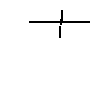

In [244]:
Image.fromarray(new_img, mode='L')

In [257]:
ahl_imgs = np.array([gen_img(x) for x in ahl_marks])
bu_imgs = np.array([gen_img(x) for x in bu_marks])
tes_imgs = np.array([gen_img(x) for x in tes_marks])

In [296]:
train_imgs = np.concatenate((ahl_imgs, bu_imgs, tes_imgs)).reshape(150, 100, 100, 1)

In [265]:
labels = [0, 1, 2] #Ahl, Bu, Tes
train_labels = np.concatenate((np.array([labels[0]]*len(ahl_imgs)),
                              np.array([labels[1]]*len(bu_imgs)),
                              np.array([labels[2]]*len(tes_imgs))
                             ))

In [295]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(labels), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 33856)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               4333696   
_________________________________________________________________
dense_23 (Dense)             (None, 3)               

In [297]:
model.fit(train_imgs, train_labels, epochs=5)

Epoch 1/5
5/5 [==============================] - 18s 3s/step - loss: 415.4114 - accuracy: 0.2573
Epoch 2/5
5/5 [==============================] - 14s 3s/step - loss: 28.0108 - accuracy: 0.3489
Epoch 3/5
5/5 [==============================] - 15s 3s/step - loss: 2.5677 - accuracy: 0.5651
Epoch 4/5
5/5 [==============================] - 16s 3s/step - loss: 0.4461 - accuracy: 0.8093
Epoch 5/5
5/5 [==============================] - 12s 2s/step - loss: 0.2742 - accuracy: 0.9248


In [288]:
model.predict([tes_imgs[0].reshape(1, 100, 100, 1)])

array([[0.00116129, 0.00384711, 0.9949916 ]], dtype=float32)

In [307]:
model.save('models/')

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


In [309]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir='models/')
tflite_model = converter.convert()

# # Save the model.
with open('models/model.tflite', 'wb') as f:
    f.write(tflite_model)